Define some parameters

In [57]:
### PARAMETERS ###
filename='../data/rnapolii_nick_traj.pdb'
threshold=0.99
nongauss='logcosh' #'exp' #
# add deflation versus parallel
negent_order=False #True # reorder PCs by decreasing negentropy prior ICA
optimize_ICset=True # optimize setsize by maximizing mutual information
niter=10

Load trajectory

In [5]:
traj = load_data(filename)

Give some stats about it

Reduce the dimensionality

In [39]:
U, L, V = perform_traj_svd(traj)

In [40]:
nPCs, var = get_truncate_order(L, threshold)

In [41]:
print("Number of components kept: ",nPCs)

Number of components kept:  3


In [42]:
Ul, Ll, Vl = truncate(U,L,V,nPCs)

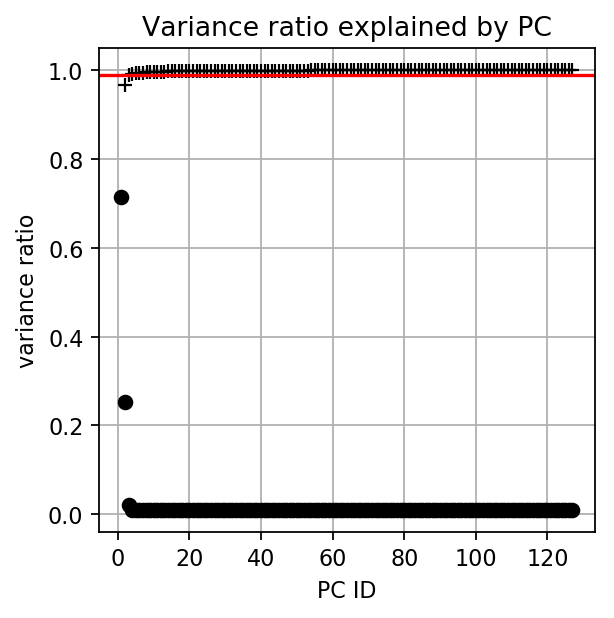

In [43]:
#plot_var(np.maximum(var,1e-2),threshold,4)
plot_var(var,threshold,4)

scan dimensions

1 0 0.0351900225106 1


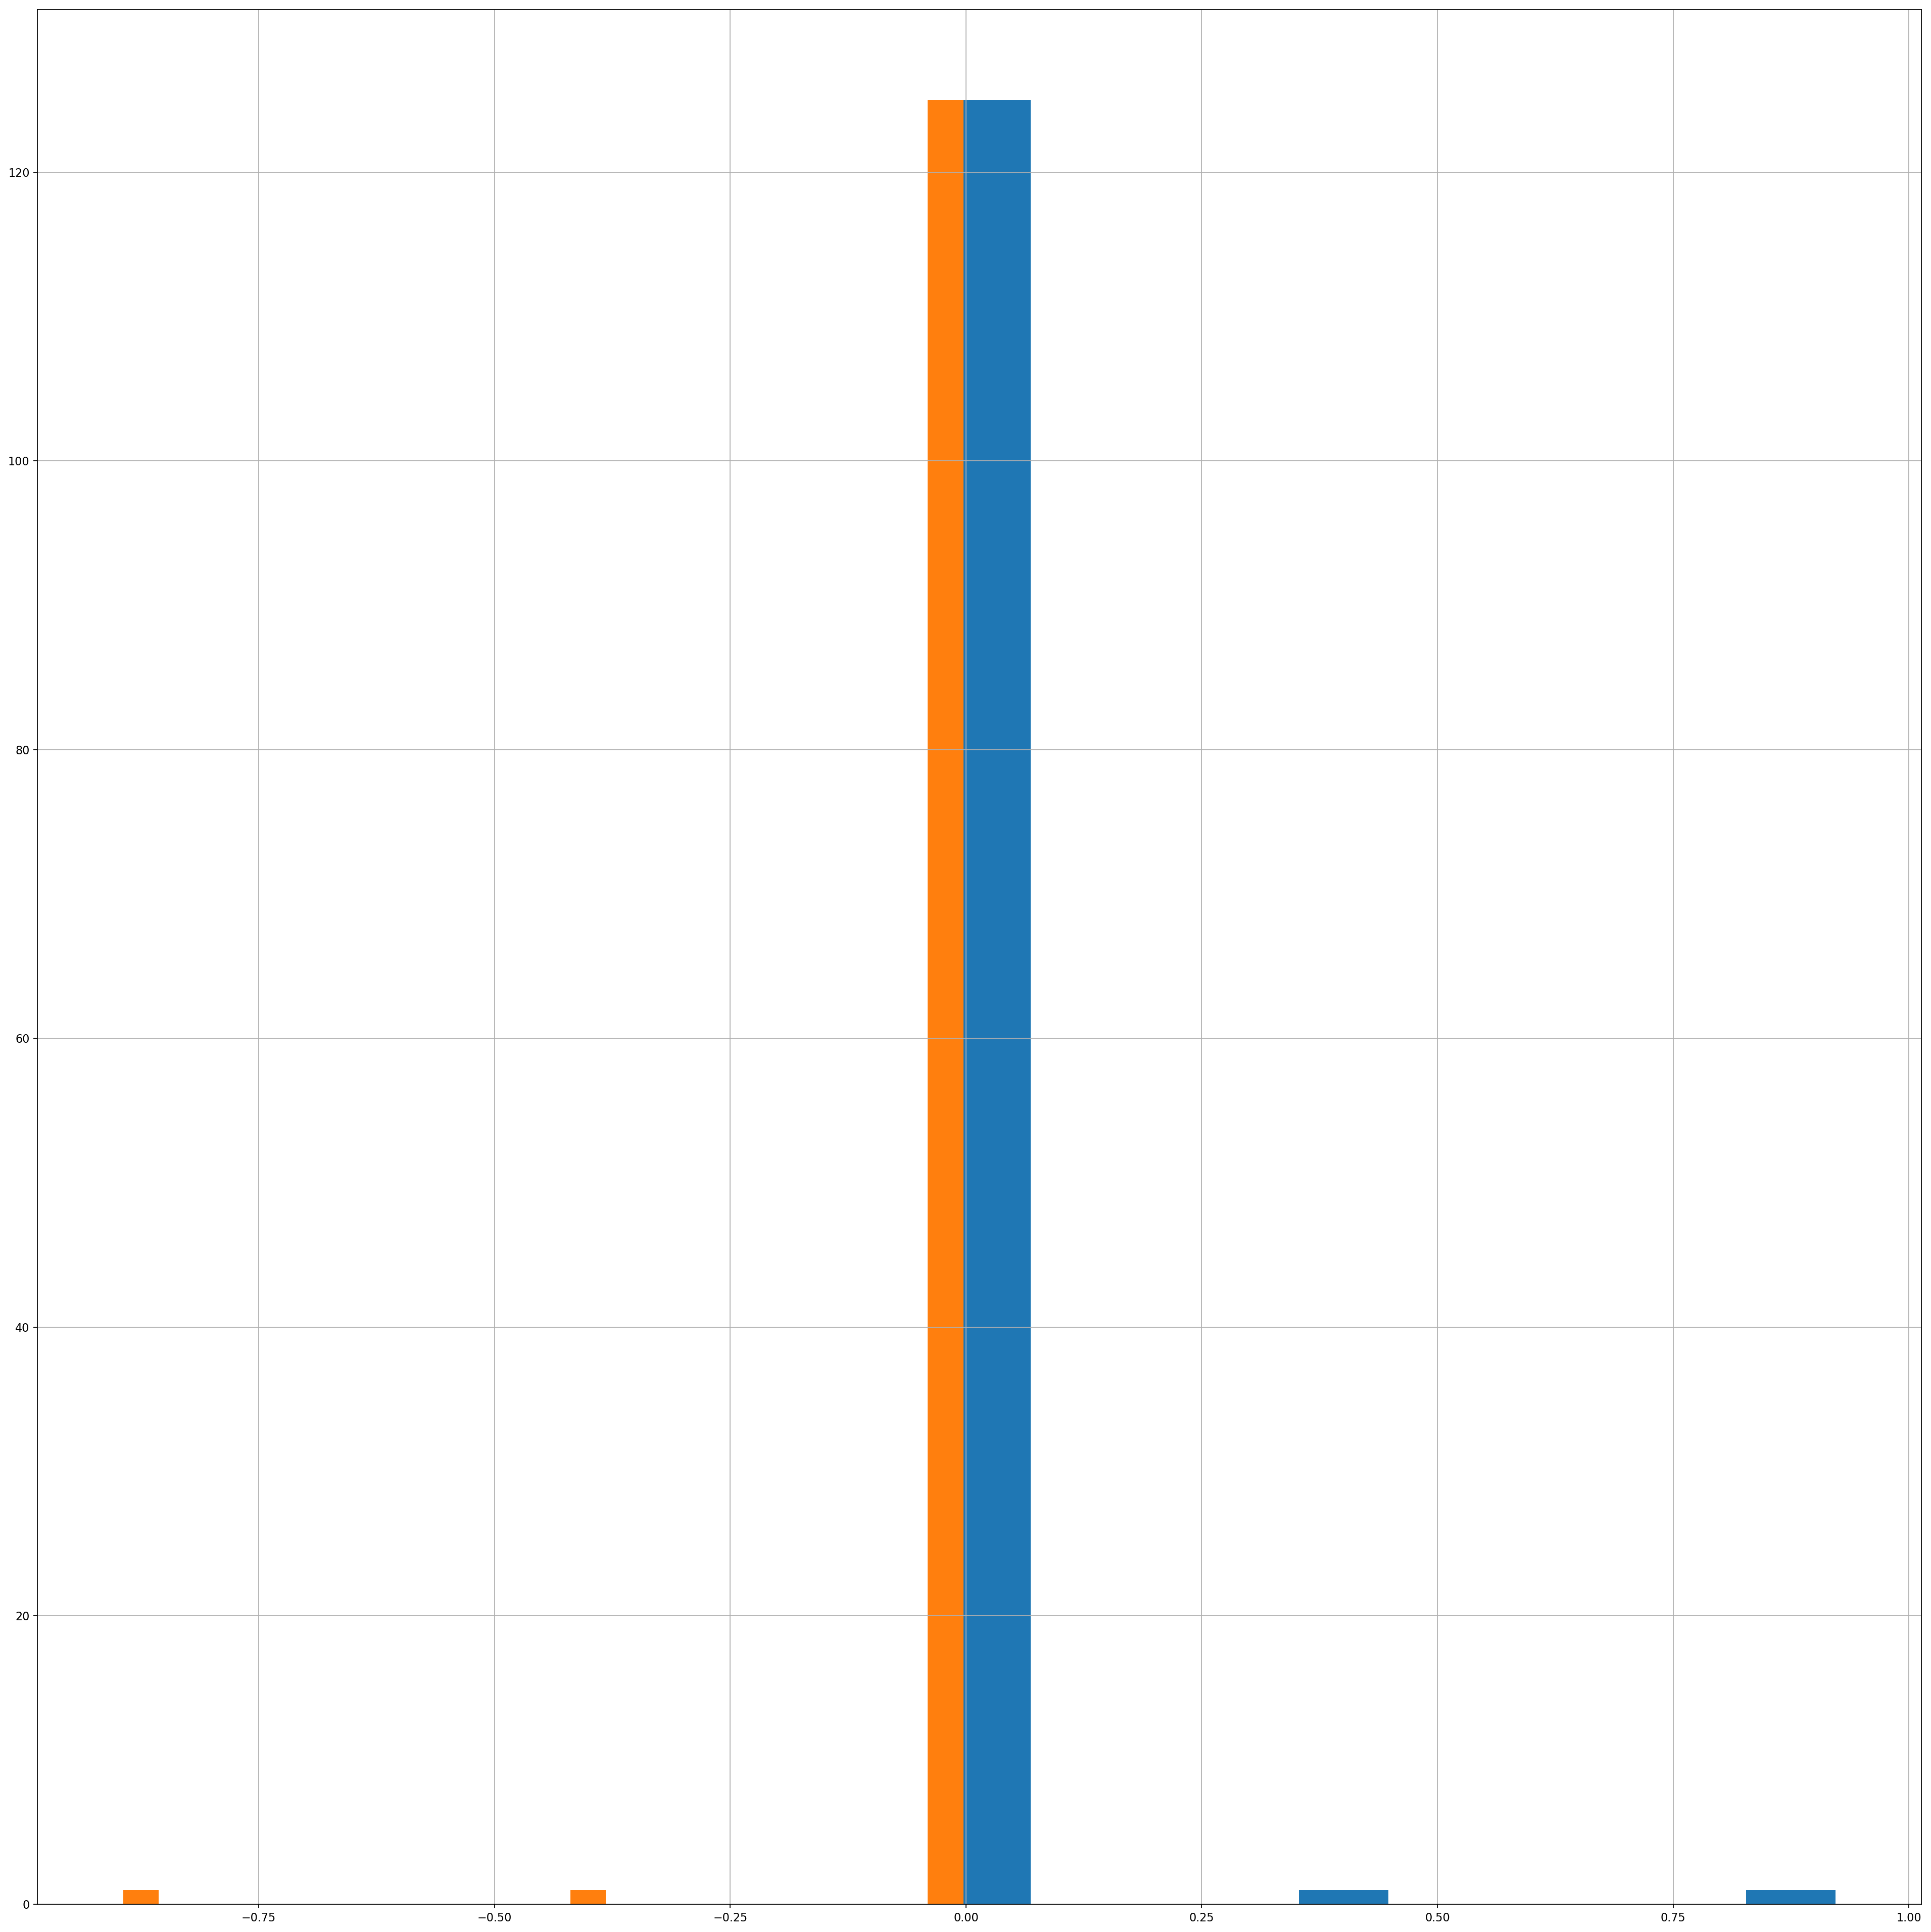

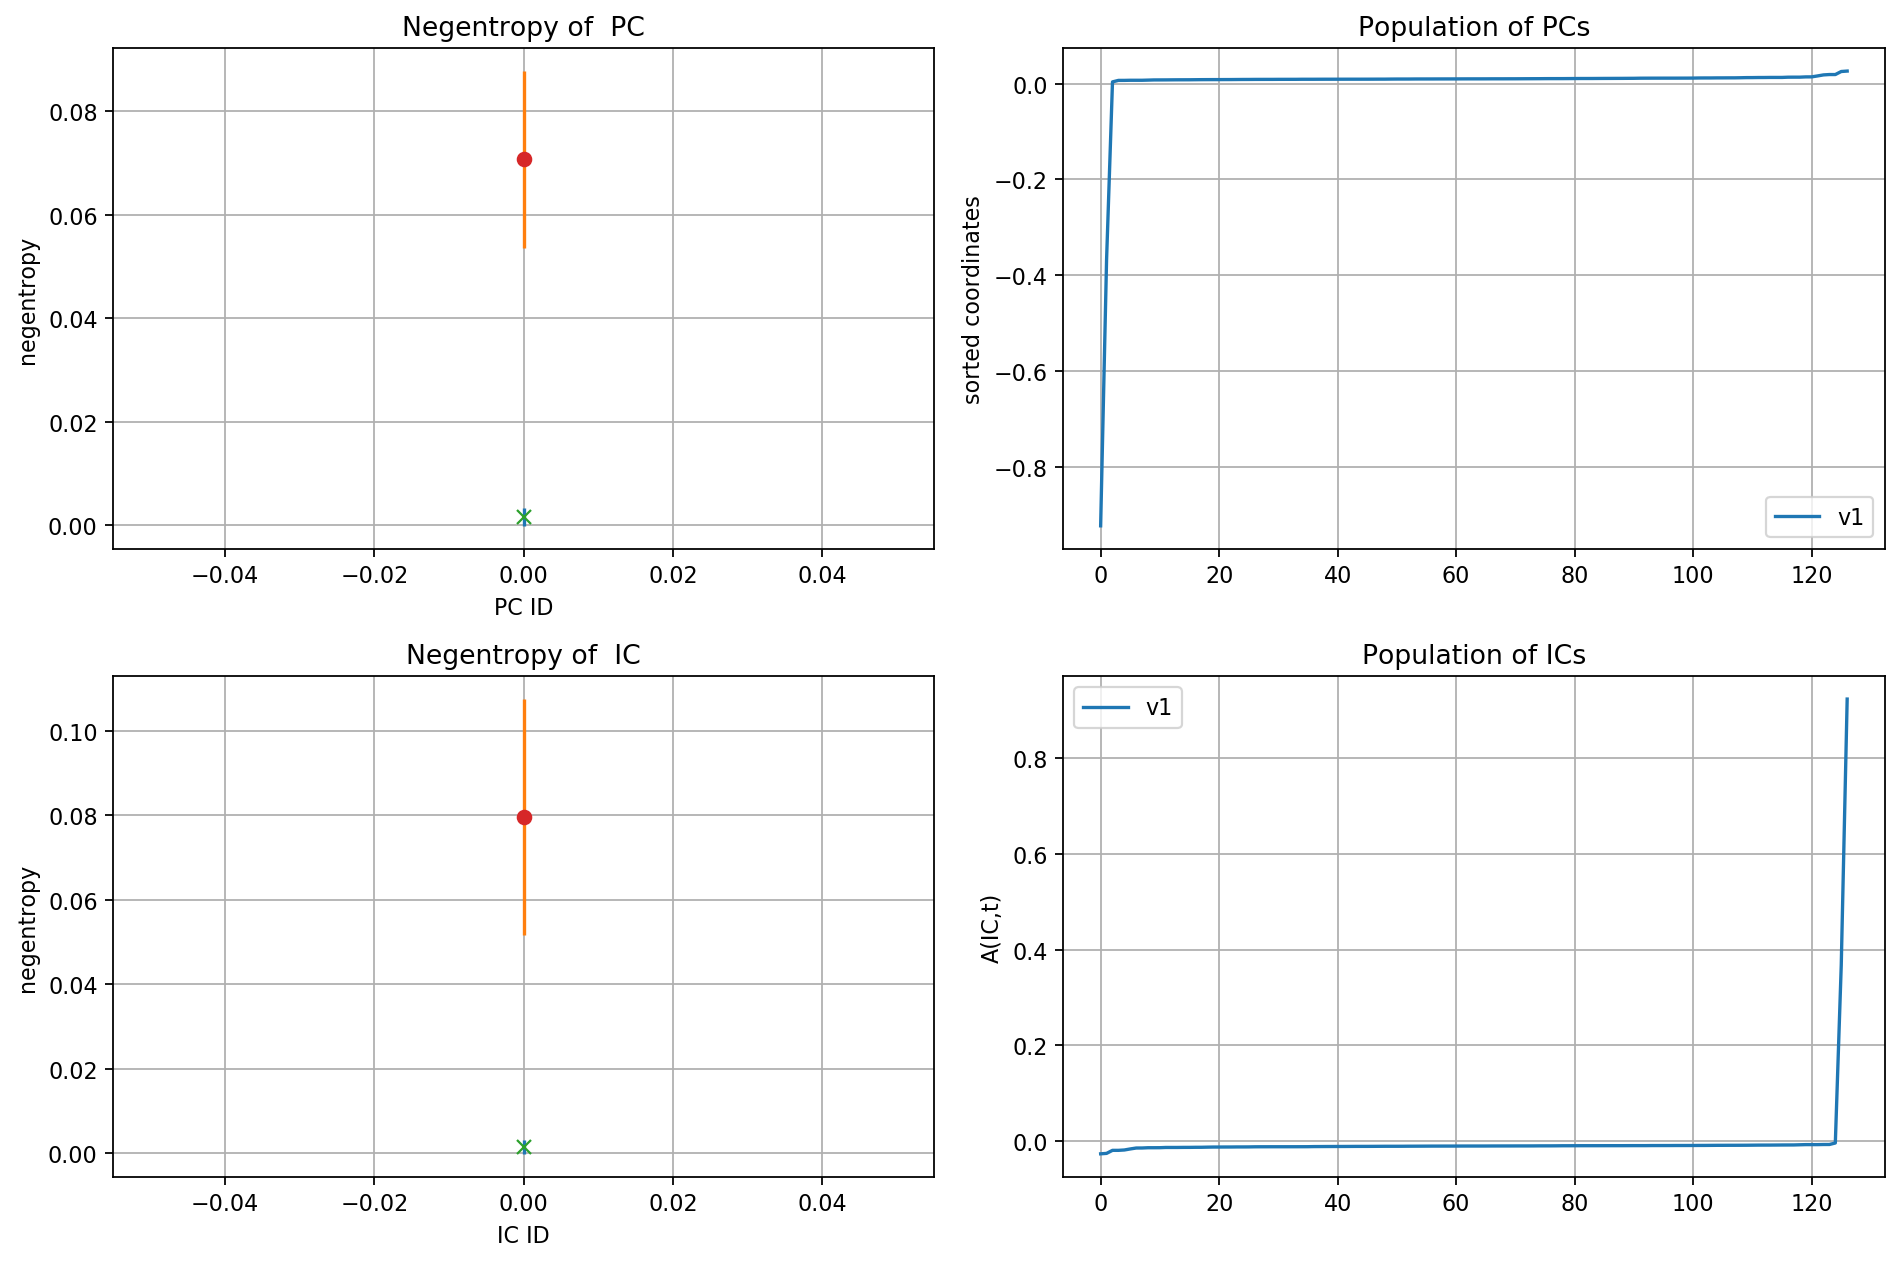

2 0 0.643300416829 4


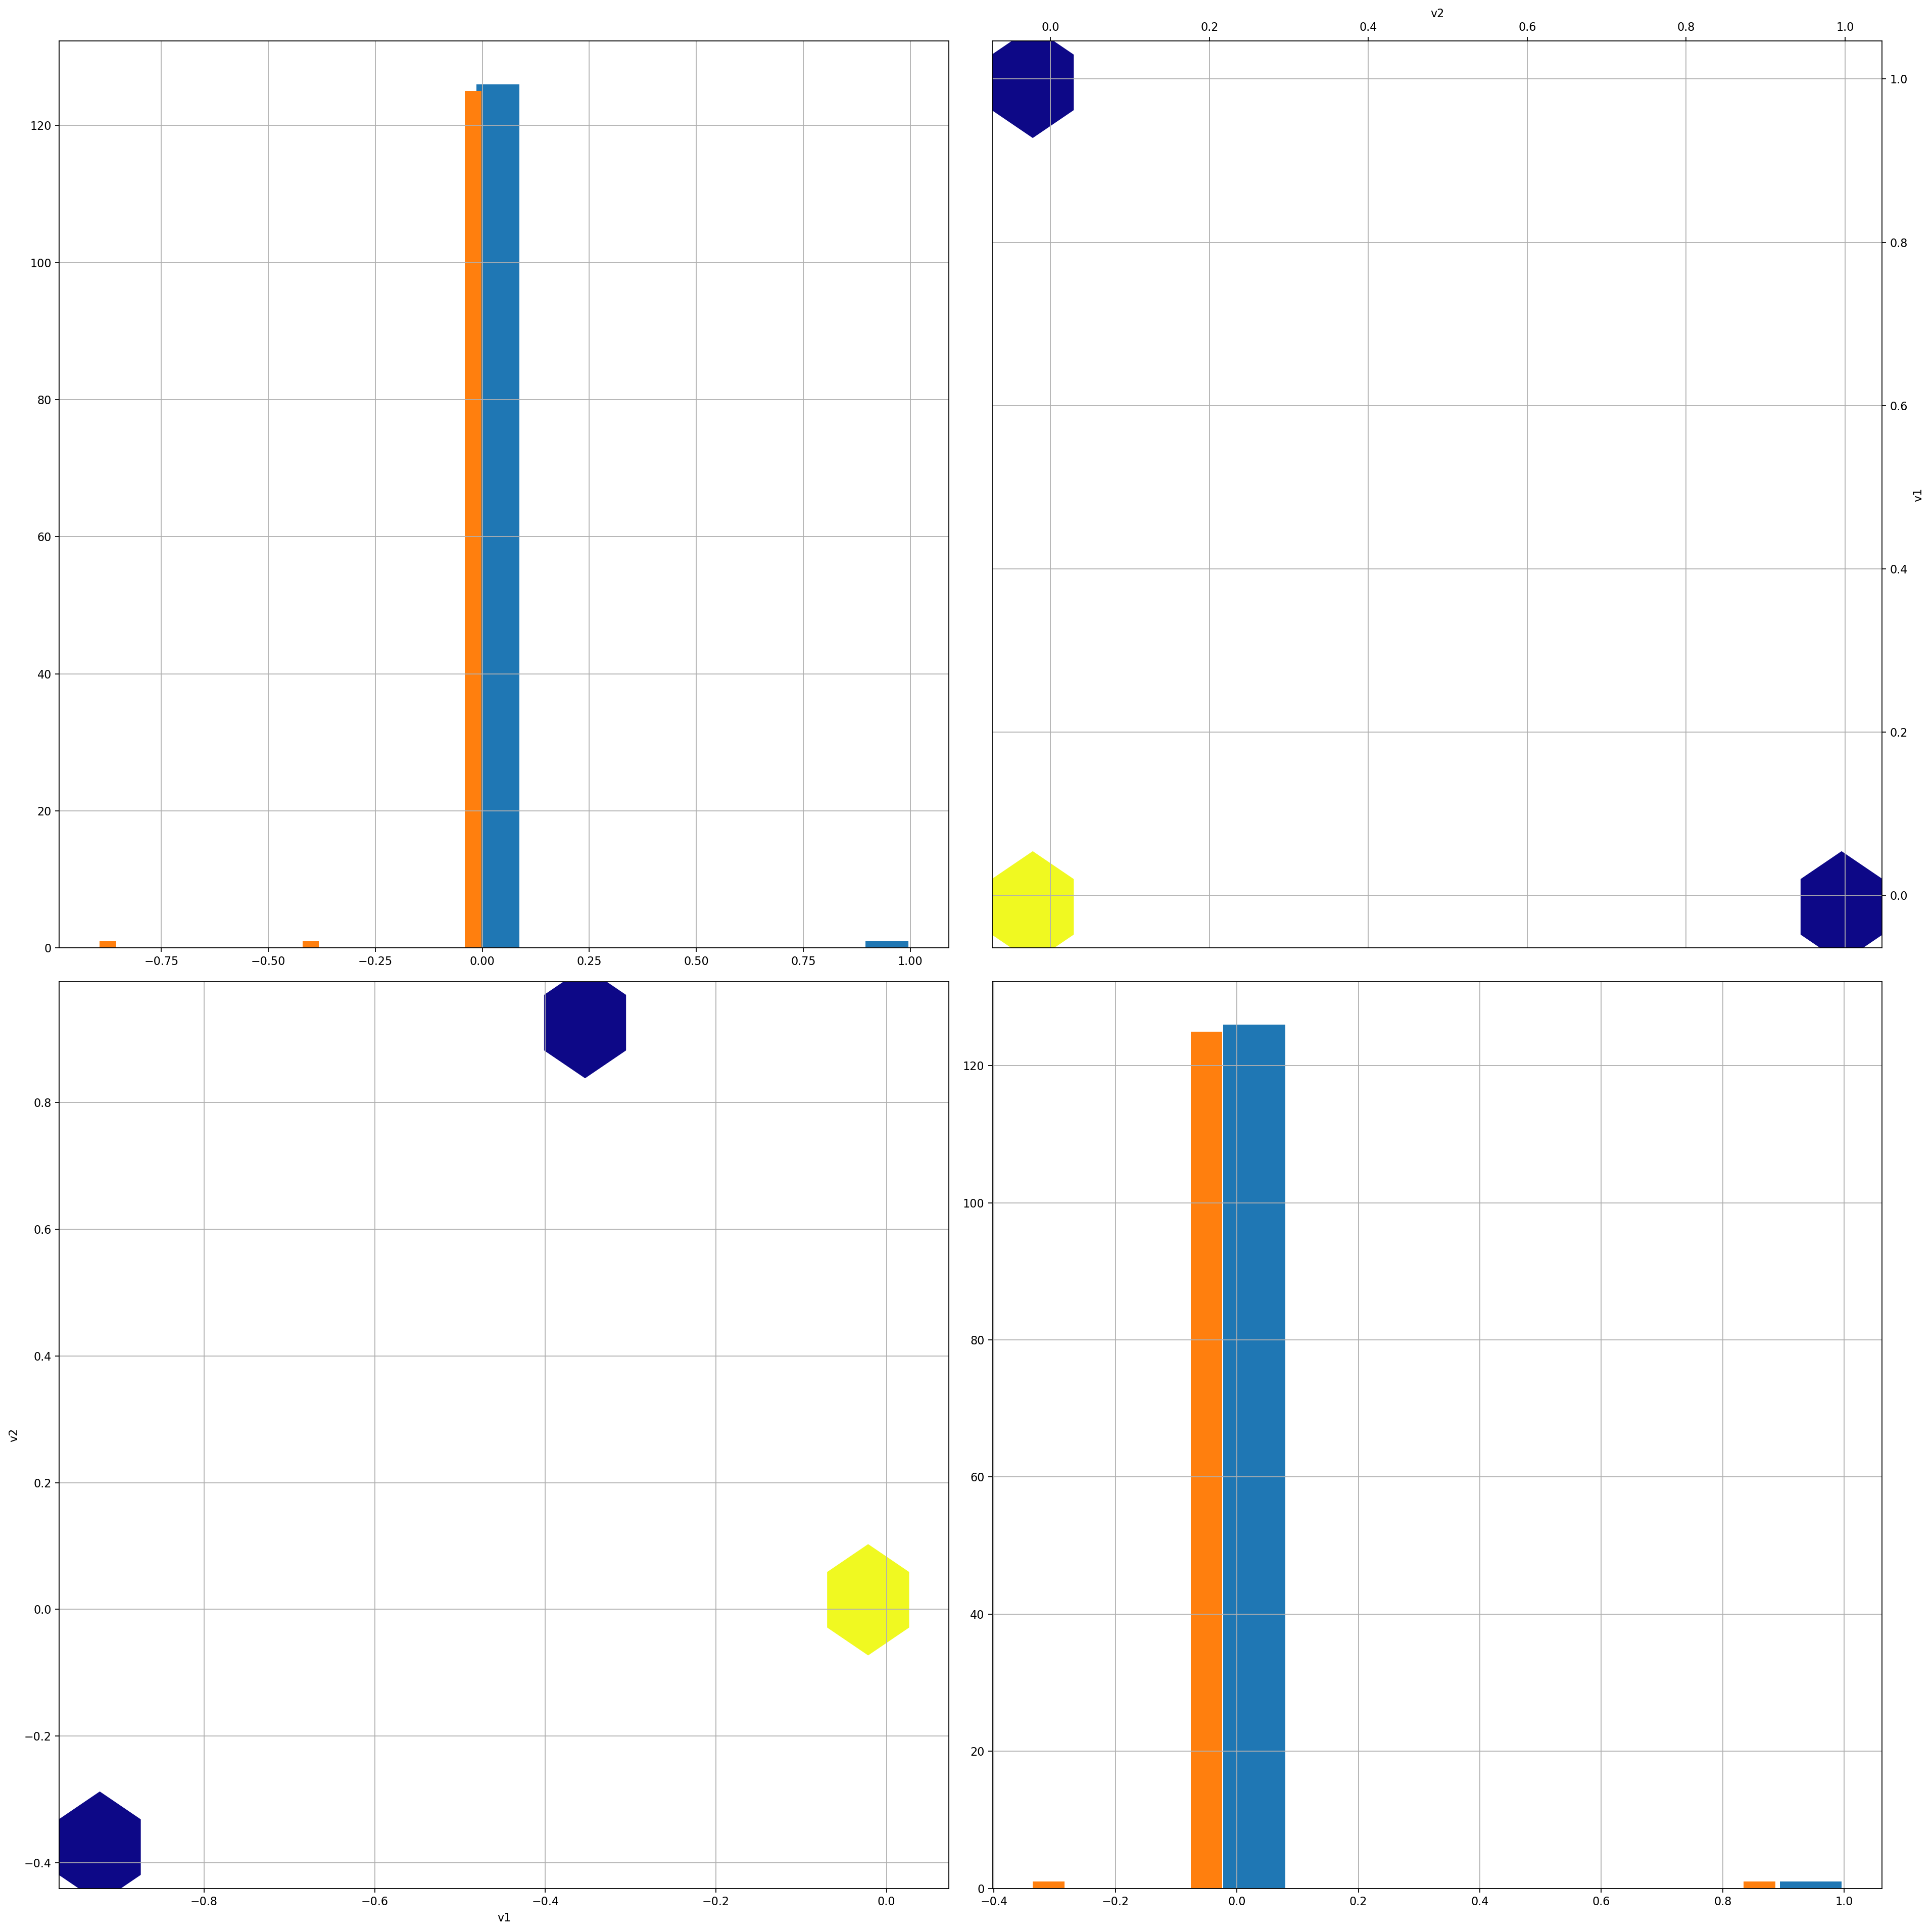

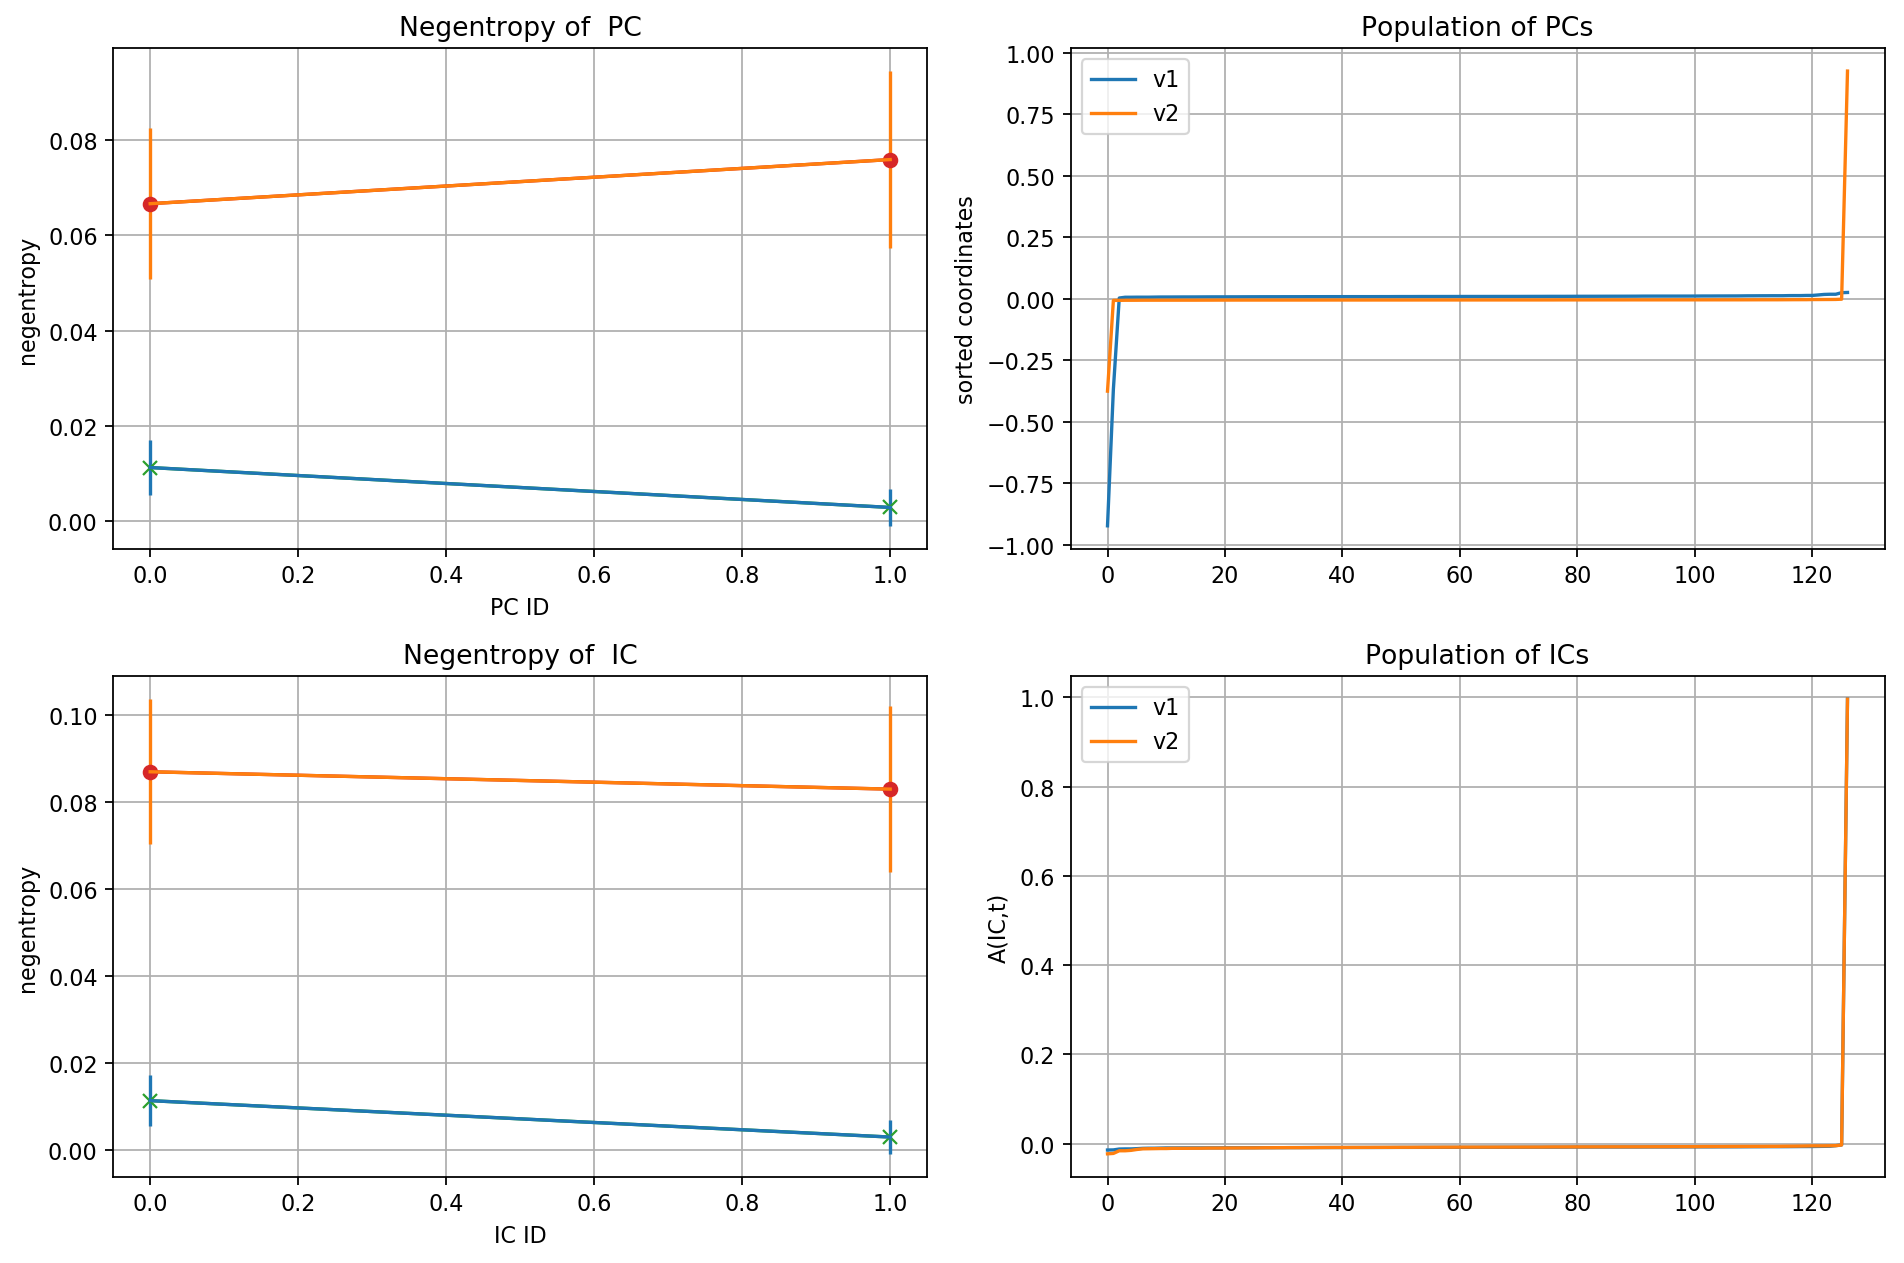

In [86]:
icalgo='parallel'#'deflation'  
ica_niter=100 # max number of iterations for FastICA to converge
ica_tol=0.0001 
signal_score_max = 0
for window_size in np.arange(1,nPCs): #np.arange(1,3): #
    for i_start in np.arange(nPCs-window_size):
        Whitened=Vl[:,i_start:i_start+window_size]
        prj_ICs, mix_ICs, unmix_ICs, iter_cvg = perform_ica(Whitened,icalgo,nongauss,ica_niter,ica_tol)
        PCscore, PCscore_var = ave_score(Whitened,window_size,niter,nongauss)
        ICscore, ICscore_var = ave_score(prj_ICs,window_size,niter,nongauss)
        signal_score = (ICscore-np.amax(PCscore))/np.sqrt(np.amax(PCscore_var))
        if(np.amax(signal_score) > signal_score_max):
            signal_score_max = np.amax(signal_score)
            print(window_size, i_start, np.amax(signal_score),iter_cvg)
            biplots(window_size,prj_ICs,Whitened,'hexbin',10)
            plot_negentropy(nongauss,window_size,Whitened,prj_ICs,niter)

# TOOLKIT

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from sklearn.decomposition import FastICA, PCA
import mdtraj as md

In [44]:
def load_data(filename):
    traj = md.load(filename)
    traj.superpose(traj, 0)
    return traj

def perform_traj_svd(traj):
    # Extract coordinates
    xyz = traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3)
    # Center 
    xyz_ctrd = xyz - np.mean(xyz, axis=0)
    # SVD
    U,L,V = LA.svd(xyz_ctrd.T, full_matrices=True)
    return U,L,V.T

def get_truncate_order(L,threshold):
    var = L**2
    var /= np.sum(var)
    for i in np.arange(0,len(var)-1,1):
        var_current = np.cumsum(var)[i]
        var_next = np.cumsum(var)[i+1]
        if(var_current < threshold and var_next > threshold):
            nPCs=i+1
    return nPCs, var

def truncate(U,L,V,nPCs):
    Ul = U[:,0:nPCs]
    Ll = L[0:nPCs]
    Vl = V[:,0:nPCs]
    return Ul, Ll, Vl

def perform_ica(X,icalgo,nongauss,ica_iter,ica_tol):
    #                   X = S A.T <=> S = X W.T
    # X (n_samples, n_features)    / S (n_samples, n_components)
    # A (n_features, n_components) / W (n_components, n_features)
    #ica = FastICA(whiten=False,algorithm=icalgo,fun=nongauss,max_iter=ica_iter, tol=ica_tol)
    ica = FastICA(whiten=True,algorithm=icalgo,fun=nongauss,max_iter=ica_iter, tol=ica_tol)
    S = ica.fit_transform(X) # Fit and apply the unmixing matrix to recover the sources
    A = ica.mixing_          # The mixing matrix
    W = ica.components_      # The unmixing matrix
    tot_iter = ica.n_iter_   # number of iterations to converge
    return S,A,W,tot_iter

def ave_score(X,n,niter,fun):
    score_ave=[]
    score_var=[]
    for i in np.arange(0,n,1):
        score_tmp = []
        for j in np.arange(0,niter,1):
            score_tmp.append(negent_score(X[:,i],fun))
        score_ave.append(np.mean(score_tmp))
        score_var.append(np.var(score_tmp))
    return score_ave,score_var

def negent_score(X,fun):
    # We compute J(X) = [E(G(X)) - E(G(Xgauss))]**2
    # We consider X (and Xgauss) to be white, in the sense that E(X,X.T)=I
    # The expectation being approximated by the sample mean in our case: np.dot(X,X.T)/n=I
    # In practice, we assume that X has already been normalized by its length [np.dot(X,X.T)=I]
    # so we rescale by np.sqrt(n) before we take the expectation value of G(X).
    length=len(X)
    Xscale = X*np.sqrt(length)
    Xgauss = np.random.randn(length)
    if(fun == 'logcosh'):
        n1 = np.mean(f_logcosh(Xscale)) #np.sum(f_logcosh(Xscale))
        n2 = np.mean(f_logcosh(Xgauss)) #np.sum(f_logcosh(Xgauss))
    elif(fun == 'exp'):
        n1 = np.mean(f_exp(Xscale))     #np.sum(f_exp(Xscale))
        n2 = np.mean(f_exp(Xgauss))     #np.sum(f_exp(Xgauss))
    elif(fun == 'rand'):
        n1 = np.mean(f_logcosh(Xgauss)) #np.sum(f_logcosh(Xgauss))
        n2 = 0 
    negent = (n2-n1)**2
    return negent

def f_logcosh(X):
    return np.log(np.cosh(X))

def f_exp(X):
    return -np.exp(-(X**2)/2)

In [82]:
def plot_var(var,threshold,size):
    fig = plt.figure(figsize=(size, size), dpi= 160, facecolor='w', edgecolor='k')
    plt.grid()
    plt.title('Variance ratio explained by PC')
    plt.xlabel('PC ID')
    plt.ylabel('variance ratio')
    #plt.semilogy(range(1,1+len(var)), np.maximum(var,1.e-2), 'ko')
    #plt.semilogy(range(1,1+len(var)), np.cumsum(var), 'k+')
    plt.plot(range(1,1+len(var)), np.maximum(var,1.e-2), 'ko')
    plt.plot(range(1,1+len(var)), np.cumsum(var), 'k+')
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.show()
    
def plot_negentropy(nongauss,n,Whitened,prj_ICs,niter):
# Preplotting...
    labels = get_labels(n)
    prj_GVs = np.random.randn(len(Whitened[:,0]),n)/np.sqrt(len(Whitened[:,0]))
    GVscore, GVscore_var = ave_score(prj_GVs,n,niter,nongauss)
    PCscore, PCscore_var = ave_score(Whitened,n,niter,nongauss)
    ICscore, ICscore_var = ave_score(prj_ICs,n,niter,nongauss)

# FIGURE 1: VARIANCE AND SPANS
    plt.figure(figsize=(12, 8), dpi= 160, facecolor='w', edgecolor='k')
    nrow=2
    ncol=2
# - NEGENTROPY of PCs
    plt.subplot(nrow,ncol,1)
    plt.grid()
    plt.title('Negentropy of  PC')
    plt.xlabel('PC ID')
    plt.ylabel('negentropy')
    plt.errorbar(np.arange(0,n,1),GVscore,yerr=np.sqrt(GVscore_var))
    plt.errorbar(np.arange(0,n,1),PCscore,yerr=np.sqrt(PCscore_var))
    plt.plot(GVscore,'x-')
    plt.plot(PCscore,'o-')
# - SPAN of PCs
    plt.subplot(nrow,ncol,2)
    plt.grid()
    plt.title('Population of PCs')
    plt.ylabel('sorted coordinates')
    for y_arr, label in zip(Whitened.T, labels):
        plt.plot(np.sort(y_arr), '-', label=label)
    plt.legend()
# - NEGENTROPY of ICs
    plt.subplot(nrow,ncol,3)
    plt.grid()
    plt.title('Negentropy of  IC')
    plt.xlabel('IC ID')
    plt.ylabel('negentropy')
    plt.errorbar(np.arange(0,n,1),GVscore,yerr=np.sqrt(GVscore_var))
    plt.errorbar(np.arange(0,n,1),ICscore,yerr=np.sqrt(ICscore_var))
    plt.plot(GVscore,'x-')
    plt.plot(ICscore,'o-')
# - SPAN of ICs
    plt.subplot(nrow,ncol,4)
    plt.grid()
    plt.title('Population of ICs')
    plt.ylabel('A(IC,t)')
    for y_arr, label in zip(prj_ICs.T, labels):
        yzero = np.mean(y_arr)
        plt.plot(np.sort(y_arr-yzero), '-', label=label)
    plt.legend()
#
    plt.tight_layout()
    plt.show()
    
def biplots(n,prj1,prj2,plottype,nbins):
    labels = get_labels(n) 
    fig = plt.figure(figsize=(24, 24), dpi= 160, facecolor='w', edgecolor='k')
    nrow=n
    ncol=n
    color_hexbin='plasma'
    #nbins = 40
    nbins_coarse = int(nbins/1)
    nbox=1 #nrow
    for i in np.arange(0,n,1):
        for j in np.arange(0,n,1):
            ax = fig.add_subplot(nrow,ncol,nbox)
            plt.grid()
            if(i<j):
                if(j<n):
                    if(i == 0):
                        ax.set_xlabel(labels[j])   
                    if(j == n - 1):
                        ax.set_ylabel(labels[i])
                    ax.xaxis.tick_top()
                    ax.yaxis.tick_right()
                    ax.xaxis.set_label_position('top')
                    ax.yaxis.set_label_position('right')
                    Ax = prj1[:,j]
                    Ay = prj1[:,i]
                    if(plottype == 'scatter'):
                        plt.scatter(Ax, Ay, cmap=color_hexbin)
                    else:
                        plt.hexbin(Ax, Ay, gridsize=nbins, cmap=color_hexbin, mincnt=1)
            elif(i==j):
                Ax = prj1[:,i]
                Ay = prj2[:,i]
                plt.hist(Ax,bins=nbins_coarse)
                plt.hist(Ay,bins=nbins_coarse,rwidth=0.4)
            else:
                if(j == 0):
                    ax.set_ylabel(labels[i])
                if(i == n - 1):
                    ax.set_xlabel(labels[j])
                Ax = prj2[:,j]
                Ay = prj2[:,i]
                if(plottype == 'scatter'):
                    plt.scatter(Ax, Ay, cmap=color_hexbin)
                else:
                    plt.hexbin(Ax, Ay, gridsize=nbins, cmap=color_hexbin, mincnt=1)
            nbox=nbox+1
    plt.tight_layout()
    plt.show()
    
def get_labels(n):
    labels = []
    for i in np.arange(0,n,1):
        labels.append('v'+str(i+1))
    return labels